In [ ]:

# Analysis Plan:
# 1. Load developability_analysis.csv and identify 5 worst allosteric binders
# 2. For each, identify aggregation hotspot using TANGO-like algorithm
# 3. Generate 4 mutants per parent (20 total) with N, Q, S, T at hotspot center
# 4. Calculate Contact-Masked MJ scores and developability metrics for all mutants
# 5. Compare parent vs mutant performance and identify rescued candidates
# 6. Save results to developability_rescued_allosteric_1.0.csv

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load the developability analysis data
df = pd.read_csv('developability_analysis.csv')

print("Dataset loaded successfully")
print(f"Total candidates: {len(df)}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Dataset loaded successfully
Total candidates: 200

Columns: ['Sequence', 'Portfolio', 'Epitope_Target', 'Motif', 'Scaffold', 'Primary_Score', 'Aggregation_Propensity', 'Solubility_Index', 'Z_Aggregation', 'Z_Solubility', 'Developability_Score', 'High_Developability', 'High_Binding', 'Dual_Optimized']

First few rows:


,Sequence,Portfolio,Epitope_Target,Motif,Scaffold,Primary_Score,Aggregation_Propensity,Solubility_Index,Z_Aggregation,Z_Solubility,Developability_Score,High_Developability,High_Binding,Dual_Optimized
0,MQYKLILNGKTLKGETTTELWCLICIWIVFKQYANDNGVDGVWTYD...,MJ,Allosteric,LWCLICIWI,1FNA,-2128.42,25.048778,-0.342857,0.965767,-0.214673,-1.180440,False,True,False
1,MQYKLILNGKTLKGETTTEWWCLICILIVFKQYANDNGVDGVWTYD...,MJ,Allosteric,WWCLICILI,1FNA,-2128.42,28.399944,-0.342857,1.351252,-0.214673,-1.565925,False,True,False
2,MQYKLILNGKTLKGETTTEIWCLWCLIIVFKQYANDNGVDGVWTYD...,MJ,Allosteric,IWCLWCLII,1FNA,-2128.42,22.640417,-0.342857,0.688733,-0.214673,-0.903406,False,True,False
3,GSDTITNATIKVQAIWCLWCLIIKVV,MJ,Allosteric,IWCLWCLII,1TEN,-2128.42,19.720500,-0.396154,0.352855,-0.808050,-1.160906,False,True,False
4,MIEKKIEKLEEHLGLAWWCLICILIQKTQPGVSVGVKPFRFGGQ,MJ,Allosteric,WWCLICILI,2QMT,-2128.42,31.359806,-0.447727,1.691725,-1.382242,-3.073968,False,True,False


In [ ]:

# Step 1: Identify the 5 worst allosteric binders by Developability_Score
allosteric_df = df[df['Epitope_Target'] == 'Allosteric'].copy()

print(f"Total allosteric binders: {len(allosteric_df)}")
print(f"\nDevelopability Score statistics:")
print(allosteric_df['Developability_Score'].describe())

# Get the 5 worst (most negative) developability scores
worst_5 = allosteric_df.nsmallest(5, 'Developability_Score')

print(f"\n5 High-Risk Allosteric Binders (worst Developability_Score):")
print(worst_5[['Sequence', 'Motif', 'Scaffold', 'Primary_Score', 
               'Aggregation_Propensity', 'Solubility_Index', 'Developability_Score']])


Total allosteric binders: 100

Developability Score statistics:
count    100.000000
mean      -1.076420
std        0.883692
min       -3.306338
25%       -1.878534
50%       -0.808807
75%       -0.377799
max        0.609234
Name: Developability_Score, dtype: float64

5 High-Risk Allosteric Binders (worst Developability_Score):
                                       Sequence      Motif Scaffold  \
9  MIEKKIEKLEEHLGLALWCLICIWIQKTQPGVSVGVKPFRFGGQ  LWCLICIWI     2QMT   
6  MIEKKIEKLEEHLGLAIWCLLCWIIQKTQPGVSVGVKPFRFGGQ  IWCLLCWII     2QMT   
4  MIEKKIEKLEEHLGLAWWCLICILIQKTQPGVSVGVKPFRFGGQ  WWCLICILI     2QMT   
8  MIEKKIEKLEEHLGLAWWCLICLIIQKTQPGVSVGVKPFRFGGQ  WWCLICLII     2QMT   
7  MIEKKIEKLEEHLGLAIWCLWCLIIQKTQPGVSVGVKPFRFGGQ  IWCLWCLII     2QMT   

   Primary_Score  Aggregation_Propensity  Solubility_Index  \
9       -2128.42               33.379889         -0.447727   
6       -2128.42               31.826037         -0.447727   
4       -2128.42               31.359806         -0.447727

In [ ]:

# Step 2: Implement TANGO-like algorithm to identify aggregation hotspots
# Using 6-residue window with Kyte-Doolittle hydrophobicity, Chou-Fasman beta-propensity, charge

# Kyte-Doolittle hydrophobicity scale
kd_hydrophobicity = {
    'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
    'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
    'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
    'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2
}

# Chou-Fasman beta-sheet propensity
cf_beta = {
    'A': 0.83, 'R': 0.93, 'N': 0.89, 'D': 0.54, 'C': 1.19,
    'Q': 1.10, 'E': 0.37, 'G': 0.75, 'H': 0.87, 'I': 1.60,
    'L': 1.30, 'K': 0.74, 'M': 1.05, 'F': 1.38, 'P': 0.55,
    'S': 0.75, 'T': 1.19, 'W': 1.37, 'Y': 1.47, 'V': 1.70
}

# Charge assignment
charge_dict = {
    'D': -1, 'E': -1, 'K': 1, 'R': 1
}

def calculate_tango_score(window):
    """Calculate TANGO-like aggregation score for a 6-residue window"""
    if len(window) != 6:
        return 0
    
    # Calculate average hydrophobicity
    hydrophobicity = np.mean([kd_hydrophobicity.get(aa, 0) for aa in window])
    
    # Calculate average beta propensity
    beta_prop = np.mean([cf_beta.get(aa, 1.0) for aa in window])
    
    # Calculate net charge
    net_charge = sum([charge_dict.get(aa, 0) for aa in window])
    
    # TANGO-like score: high hydrophobicity + high beta propensity - charge penalty
    score = hydrophobicity * beta_prop - abs(net_charge) * 2
    
    return score

def find_aggregation_hotspot(sequence):
    """Find the 6-residue window with highest aggregation score"""
    best_score = -np.inf
    best_window = None
    best_position = None
    
    for i in range(len(sequence) - 5):
        window = sequence[i:i+6]
        score = calculate_tango_score(window)
        
        if score > best_score:
            best_score = score
            best_window = window
            best_position = i
    
    return best_window, best_position, best_score

# Test on the 5 worst candidates
print("Aggregation Hotspots for 5 High-Risk Allosteric Binders:\n")
hotspot_data = []

for idx, row in worst_5.iterrows():
    seq = row['Sequence']
    hotspot, position, score = find_aggregation_hotspot(seq)
    
    hotspot_data.append({
        'Parent_Index': idx,
        'Parent_Sequence': seq,
        'Motif': row['Motif'],
        'Scaffold': row['Scaffold'],
        'Parent_MJ_Score': row['Primary_Score'],
        'Parent_Developability': row['Developability_Score'],
        'Hotspot_Window': hotspot,
        'Hotspot_Position': position,
        'Hotspot_Score': score,
        'Central_Residue': hotspot[2] if hotspot else None,
        'Central_Position': position + 2 if position is not None else None
    })
    
    print(f"Parent {idx}:")
    print(f"  Motif: {row['Motif']}, Scaffold: {row['Scaffold']}")
    print(f"  Hotspot: {hotspot} at position {position}")
    print(f"  Aggregation score: {score:.2f}")
    print(f"  Central residue to mutate: {hotspot[2]} (position {position + 2})")
    print()

hotspot_df = pd.DataFrame(hotspot_data)


Aggregation Hotspots for 5 High-Risk Allosteric Binders:

Parent 9:
  Motif: LWCLICIWI, Scaffold: 2QMT
  Hotspot: LICIWI at position 19
  Aggregation score: 4.55
  Central residue to mutate: C (position 21)

Parent 6:
  Motif: IWCLLCWII, Scaffold: 2QMT
  Hotspot: LLCWII at position 19
  Aggregation score: 4.23
  Central residue to mutate: C (position 21)

Parent 4:
  Motif: WWCLICILI, Scaffold: 2QMT
  Hotspot: LICILI at position 19
  Aggregation score: 5.63
  Central residue to mutate: C (position 21)

Parent 8:
  Motif: WWCLICLII, Scaffold: 2QMT
  Hotspot: LICLII at position 19
  Aggregation score: 5.63
  Central residue to mutate: C (position 21)

Parent 7:
  Motif: IWCLWCLII, Scaffold: 2QMT
  Hotspot: LWCLII at position 19
  Aggregation score: 4.23
  Central residue to mutate: C (position 21)



In [ ]:

# Step 3: Generate mutants by replacing central residue with N, Q, S, T
mutants_data = []

for idx, hotspot_row in hotspot_df.iterrows():
    parent_seq = hotspot_row['Parent_Sequence']
    central_pos = hotspot_row['Central_Position']
    
    # Generate 4 mutants
    for mutant_aa in ['N', 'Q', 'S', 'T']:
        mutant_seq = parent_seq[:central_pos] + mutant_aa + parent_seq[central_pos+1:]
        
        mutants_data.append({
            'Parent_Index': hotspot_row['Parent_Index'],
            'Parent_Sequence': parent_seq,
            'Parent_Motif': hotspot_row['Motif'],
            'Scaffold': hotspot_row['Scaffold'],
            'Parent_MJ_Score': hotspot_row['Parent_MJ_Score'],
            'Parent_Developability': hotspot_row['Parent_Developability'],
            'Hotspot_Window': hotspot_row['Hotspot_Window'],
            'Hotspot_Position': hotspot_row['Hotspot_Position'],
            'Central_Residue_Original': hotspot_row['Central_Residue'],
            'Central_Position': central_pos,
            'Mutant_Residue': mutant_aa,
            'Mutant_Sequence': mutant_seq,
            'Mutation_Label': f"{hotspot_row['Central_Residue']}{central_pos}{mutant_aa}"
        })

mutants_df = pd.DataFrame(mutants_data)

print(f"Generated {len(mutants_df)} mutant sequences (5 parents x 4 mutations each)")
print(f"\nFirst few mutants:")
print(mutants_df[['Parent_Index', 'Mutation_Label', 'Mutant_Residue', 'Scaffold']].head(10))


Generated 20 mutant sequences (5 parents x 4 mutations each)

First few mutants:
   Parent_Index Mutation_Label Mutant_Residue Scaffold
0             9           C21N              N     2QMT
1             9           C21Q              Q     2QMT
2             9           C21S              S     2QMT
3             9           C21T              T     2QMT
4             6           C21N              N     2QMT
5             6           C21Q              Q     2QMT
6             6           C21S              S     2QMT
7             6           C21T              T     2QMT
8             4           C21N              N     2QMT
9             4           C21Q              Q     2QMT


In [ ]:

# Step 4: Calculate Contact-Masked MJ scores for all mutants
# Using the 31-residue allosteric epitope and 30% percentile method

# Miyazawa-Jernigan contact potential matrix
mj_matrix = {
    ('C', 'C'): -5.44, ('C', 'M'): -5.46, ('C', 'F'): -5.80, ('C', 'I'): -5.50,
    ('C', 'L'): -5.83, ('C', 'V'): -5.40, ('C', 'W'): -5.81, ('C', 'Y'): -5.49,
    ('C', 'A'): -4.99, ('C', 'G'): -4.58, ('C', 'T'): -4.73, ('C', 'S'): -4.59,
    ('C', 'N'): -4.49, ('C', 'Q'): -4.61, ('C', 'D'): -4.10, ('C', 'E'): -4.16,
    ('C', 'H'): -4.82, ('C', 'R'): -4.28, ('C', 'K'): -3.92, ('C', 'P'): -4.18,
    ('M', 'M'): -5.46, ('M', 'F'): -5.71, ('M', 'I'): -5.32, ('M', 'L'): -5.65,
    ('M', 'V'): -5.32, ('M', 'W'): -5.55, ('M', 'Y'): -5.29, ('M', 'A'): -4.99,
    ('M', 'G'): -4.59, ('M', 'T'): -4.68, ('M', 'S'): -4.54, ('M', 'N'): -4.36,
    ('M', 'Q'): -4.55, ('M', 'D'): -4.02, ('M', 'E'): -4.03, ('M', 'H'): -4.69,
    ('M', 'R'): -4.12, ('M', 'K'): -3.93, ('M', 'P'): -4.09,
    ('F', 'F'): -6.16, ('F', 'I'): -5.65, ('F', 'L'): -5.96, ('F', 'V'): -5.58,
    ('F', 'W'): -6.16, ('F', 'Y'): -5.89, ('F', 'A'): -5.20, ('F', 'G'): -4.80,
    ('F', 'T'): -4.91, ('F', 'S'): -4.70, ('F', 'N'): -4.60, ('F', 'Q'): -4.76,
    ('F', 'D'): -4.21, ('F', 'E'): -4.22, ('F', 'H'): -5.02, ('F', 'R'): -4.35,
    ('F', 'K'): -4.13, ('F', 'P'): -4.38,
    ('I', 'I'): -5.25, ('I', 'L'): -5.61, ('I', 'V'): -5.18, ('I', 'W'): -5.55,
    ('I', 'Y'): -5.25, ('I', 'A'): -4.92, ('I', 'G'): -4.53, ('I', 'T'): -4.64,
    ('I', 'S'): -4.41, ('I', 'N'): -4.28, ('I', 'Q'): -4.36, ('I', 'D'): -3.89,
    ('I', 'E'): -3.89, ('I', 'H'): -4.54, ('I', 'R'): -3.96, ('I', 'K'): -3.77,
    ('I', 'P'): -3.98,
    ('L', 'L'): -5.92, ('L', 'V'): -5.49, ('L', 'W'): -5.85, ('L', 'Y'): -5.55,
    ('L', 'A'): -5.22, ('L', 'G'): -4.81, ('L', 'T'): -4.90, ('L', 'S'): -4.68,
    ('L', 'N'): -4.53, ('L', 'Q'): -4.63, ('L', 'D'): -4.14, ('L', 'E'): -4.15,
    ('L', 'H'): -4.77, ('L', 'R'): -4.19, ('L', 'K'): -4.02, ('L', 'P'): -4.20,
    ('V', 'V'): -5.18, ('V', 'W'): -5.47, ('V', 'Y'): -5.18, ('V', 'A'): -4.90,
    ('V', 'G'): -4.51, ('V', 'T'): -4.62, ('V', 'S'): -4.40, ('V', 'N'): -4.26,
    ('V', 'Q'): -4.33, ('V', 'D'): -3.88, ('V', 'E'): -3.87, ('V', 'H'): -4.48,
    ('V', 'R'): -3.94, ('V', 'K'): -3.76, ('V', 'P'): -3.97,
    ('W', 'W'): -6.16, ('W', 'Y'): -5.87, ('W', 'A'): -5.14, ('W', 'G'): -4.75,
    ('W', 'T'): -4.88, ('W', 'S'): -4.66, ('W', 'N'): -4.52, ('W', 'Q'): -4.70,
    ('W', 'D'): -4.18, ('W', 'E'): -4.18, ('W', 'H'): -4.98, ('W', 'R'): -4.29,
    ('W', 'K'): -4.11, ('W', 'P'): -4.31,
    ('Y', 'Y'): -5.60, ('Y', 'A'): -4.91, ('Y', 'G'): -4.53, ('Y', 'T'): -4.68,
    ('Y', 'S'): -4.47, ('Y', 'N'): -4.35, ('Y', 'Q'): -4.50, ('Y', 'D'): -4.00,
    ('Y', 'E'): -4.00, ('Y', 'H'): -4.75, ('Y', 'R'): -4.10, ('Y', 'K'): -3.91,
    ('Y', 'P'): -4.11,
    ('A', 'A'): -4.81, ('A', 'G'): -4.58, ('A', 'T'): -4.54, ('A', 'S'): -4.32,
    ('A', 'N'): -4.21, ('A', 'Q'): -4.28, ('A', 'D'): -3.87, ('A', 'E'): -3.86,
    ('A', 'H'): -4.40, ('A', 'R'): -3.91, ('A', 'K'): -3.78, ('A', 'P'): -3.82,
    ('G', 'G'): -4.33, ('G', 'T'): -4.25, ('G', 'S'): -4.02, ('G', 'N'): -3.93,
    ('G', 'Q'): -3.98, ('G', 'D'): -3.59, ('G', 'E'): -3.58, ('G', 'H'): -4.08,
    ('G', 'R'): -3.63, ('G', 'K'): -3.52, ('G', 'P'): -3.50,
    ('T', 'T'): -4.40, ('T', 'S'): -4.18, ('T', 'N'): -4.04, ('T', 'Q'): -4.13,
    ('T', 'D'): -3.73, ('T', 'E'): -3.73, ('T', 'H'): -4.22, ('T', 'R'): -3.75,
    ('T', 'K'): -3.62, ('T', 'P'): -3.65,
    ('S', 'S'): -3.97, ('S', 'N'): -3.85, ('S', 'Q'): -3.92, ('S', 'D'): -3.52,
    ('S', 'E'): -3.52, ('S', 'H'): -4.02, ('S', 'R'): -3.56, ('S', 'K'): -3.45,
    ('S', 'P'): -3.45,
    ('N', 'N'): -3.79, ('N', 'Q'): -3.85, ('N', 'D'): -3.46, ('N', 'E'): -3.46,
    ('N', 'H'): -3.94, ('N', 'R'): -3.50, ('N', 'K'): -3.39, ('N', 'P'): -3.38,
    ('Q', 'Q'): -3.92, ('Q', 'D'): -3.51, ('Q', 'E'): -3.51, ('Q', 'H'): -4.02,
    ('Q', 'R'): -3.56, ('Q', 'K'): -3.44, ('Q', 'P'): -3.42,
    ('D', 'D'): -3.14, ('D', 'E'): -3.14, ('D', 'H'): -3.60, ('D', 'R'): -3.17,
    ('D', 'K'): -3.08, ('D', 'P'): -3.07,
    ('E', 'E'): -3.14, ('E', 'H'): -3.60, ('E', 'R'): -3.17, ('E', 'K'): -3.08,
    ('E', 'P'): -3.07,
    ('H', 'H'): -4.16, ('H', 'R'): -3.64, ('H', 'K'): -3.51, ('H', 'P'): -3.52,
    ('R', 'R'): -3.20, ('R', 'K'): -3.11, ('R', 'P'): -3.07,
    ('K', 'K'): -3.01, ('K', 'P'): -2.99,
    ('P', 'P'): -3.07
}

def get_mj_score(aa1, aa2):
    """Get MJ score for a pair of amino acids (symmetric)"""
    if aa1 == aa2:
        return mj_matrix.get((aa1, aa2), 0)
    pair1 = (aa1, aa2)
    pair2 = (aa2, aa1)
    return mj_matrix.get(pair1, mj_matrix.get(pair2, 0))

def calculate_contact_masked_mj(sequence, epitope, percentile=30):
    """Calculate Contact-Masked MJ score using top 30% most favorable interactions"""
    all_scores = []
    
    # Calculate all pairwise interactions
    for aa_seq in sequence:
        for aa_epi in epitope:
            score = get_mj_score(aa_seq, aa_epi)
            all_scores.append(score)
    
    # Get the 30th percentile threshold (most favorable = most negative)
    threshold = np.percentile(all_scores, percentile)
    
    # Sum only the interactions below this threshold (most favorable)
    masked_score = sum([s for s in all_scores if s <= threshold])
    
    return masked_score

# Define the 31-residue allosteric epitope
allosteric_epitope = "KGVTPSQIGRLHFNSTGWNVTDKTQCIQKAV"

print("Calculating Contact-Masked MJ scores for all 20 mutants...")
print(f"Epitope: {allosteric_epitope} (length: {len(allosteric_epitope)})")
print()

# Calculate MJ scores for all mutants
mutants_df['Mutant_MJ_Score'] = mutants_df['Mutant_Sequence'].apply(
    lambda seq: calculate_contact_masked_mj(seq, allosteric_epitope)
)

print("Sample of MJ scores:")
print(mutants_df[['Parent_Index', 'Mutation_Label', 'Parent_MJ_Score', 'Mutant_MJ_Score']].head(10))


Calculating Contact-Masked MJ scores for all 20 mutants...
Epitope: KGVTPSQIGRLHFNSTGWNVTDKTQCIQKAV (length: 31)

Sample of MJ scores:
   Parent_Index Mutation_Label  Parent_MJ_Score  Mutant_MJ_Score
0             9           C21N         -2128.42         -2090.13
1             9           C21Q         -2128.42         -2085.83
2             9           C21S         -2128.42         -2099.57
3             9           C21T         -2128.42         -2109.69
4             6           C21N         -2128.42         -2090.13
5             6           C21Q         -2128.42         -2085.83
6             6           C21S         -2128.42         -2099.57
7             6           C21T         -2128.42         -2109.69
8             4           C21N         -2128.42         -2090.13
9             4           C21Q         -2128.42         -2085.83


In [ ]:

# Step 4 continued: Calculate full developability profile for all mutants
# Using the same TANGO-like algorithm and Wilkinson-Harrison solubility model

def calculate_aggregation_propensity(sequence):
    """Calculate aggregation propensity using TANGO-like algorithm"""
    aggregation_scores = []
    
    for i in range(len(sequence) - 5):
        window = sequence[i:i+6]
        score = calculate_tango_score(window)
        aggregation_scores.append(score)
    
    # Return the sum of all window scores
    return sum(aggregation_scores)

def calculate_solubility_index(sequence):
    """Calculate solubility index using Wilkinson-Harrison model"""
    # Wilkinson-Harrison coefficients
    wh_coefficients = {
        'A': 0.070, 'R': 0.170, 'N': 0.090, 'D': 0.110, 'C': -0.090,
        'Q': 0.070, 'E': 0.170, 'G': 0.080, 'H': -0.010, 'I': -0.160,
        'L': -0.160, 'K': 0.180, 'M': -0.130, 'F': -0.170, 'P': 0.010,
        'S': 0.070, 'T': 0.070, 'W': -0.170, 'Y': -0.130, 'V': -0.140
    }
    
    # Calculate average coefficient
    coefficients = [wh_coefficients.get(aa, 0) for aa in sequence]
    solubility = np.mean(coefficients)
    
    return solubility

print("Calculating developability metrics for all 20 mutants...")

# Calculate aggregation propensity
mutants_df['Mutant_Aggregation'] = mutants_df['Mutant_Sequence'].apply(
    calculate_aggregation_propensity
)

# Calculate solubility index
mutants_df['Mutant_Solubility'] = mutants_df['Mutant_Sequence'].apply(
    calculate_solubility_index
)

# Calculate z-scores for aggregation and solubility
mutants_df['Mutant_Z_Aggregation'] = (
    (mutants_df['Mutant_Aggregation'] - mutants_df['Mutant_Aggregation'].mean()) / 
    mutants_df['Mutant_Aggregation'].std()
)

mutants_df['Mutant_Z_Solubility'] = (
    (mutants_df['Mutant_Solubility'] - mutants_df['Mutant_Solubility'].mean()) / 
    mutants_df['Mutant_Solubility'].std()
)

# Calculate composite developability score
mutants_df['Mutant_Developability'] = (
    mutants_df['Mutant_Z_Solubility'] - mutants_df['Mutant_Z_Aggregation']
)

print("\nSample of developability metrics:")
print(mutants_df[['Parent_Index', 'Mutation_Label', 
                   'Mutant_Aggregation', 'Mutant_Solubility', 
                   'Mutant_Developability']].head(10))


Calculating developability metrics for all 20 mutants...

Sample of developability metrics:
   Parent_Index Mutation_Label  Mutant_Aggregation  Mutant_Solubility  \
0             9           C21N          -49.945056          -0.005682   
1             9           C21Q          -49.666806          -0.006136   
2             9           C21S          -46.640806          -0.006136   
3             9           C21T          -45.723222          -0.006136   
4             6           C21N          -50.074083          -0.005682   
5             6           C21Q          -49.843667          -0.006136   
6             6           C21S          -46.845194          -0.006136   
7             6           C21T          -46.031806          -0.006136   
8             4           C21N          -49.427500          -0.005682   
9             4           C21Q          -49.067000          -0.006136   

   Mutant_Developability  
0               2.773162  
1               0.375318  
2              -1.22243

In [ ]:

# Step 5: Calculate changes (deltas) and evaluate rescue success

# Calculate changes from parent
mutants_df['Delta_Binding'] = mutants_df['Mutant_MJ_Score'] - mutants_df['Parent_MJ_Score']
mutants_df['Delta_Developability'] = mutants_df['Mutant_Developability'] - mutants_df['Parent_Developability']

# Calculate percentage change in binding score
mutants_df['Percent_Binding_Change'] = (mutants_df['Delta_Binding'] / abs(mutants_df['Parent_MJ_Score'])) * 100

# Define rescue criteria:
# 1. ΔDevelopability > 1.0 (significant improvement)
# 2. ΔBinding less positive than 5% of original score (minimal penalty)
mutants_df['Rescue_Success'] = (
    (mutants_df['Delta_Developability'] > 1.0) & 
    (mutants_df['Percent_Binding_Change'] < 5.0)
)

print("Summary of rescue attempts:")
print(f"Total mutants: {len(mutants_df)}")
print(f"Successfully rescued: {mutants_df['Rescue_Success'].sum()}")
print()

print("Distribution of outcomes:")
print(f"  ΔDevelopability > 1.0: {(mutants_df['Delta_Developability'] > 1.0).sum()}")
print(f"  ΔBinding < 5% original: {(mutants_df['Percent_Binding_Change'] < 5.0).sum()}")
print(f"  Both criteria met: {mutants_df['Rescue_Success'].sum()}")
print()

# Show all mutants with their performance
print("All mutants with performance metrics:")
comparison_cols = ['Parent_Index', 'Mutation_Label', 'Mutant_Residue', 
                   'Parent_MJ_Score', 'Mutant_MJ_Score', 'Delta_Binding',
                   'Percent_Binding_Change', 'Parent_Developability', 
                   'Mutant_Developability', 'Delta_Developability', 'Rescue_Success']
print(mutants_df[comparison_cols].to_string())


Summary of rescue attempts:
Total mutants: 20
Successfully rescued: 20

Distribution of outcomes:
  ΔDevelopability > 1.0: 20
  ΔBinding < 5% original: 20
  Both criteria met: 20

All mutants with performance metrics:
    Parent_Index Mutation_Label Mutant_Residue  Parent_MJ_Score  Mutant_MJ_Score  Delta_Binding  Percent_Binding_Change  Parent_Developability  Mutant_Developability  Delta_Developability  Rescue_Success
0              9           C21N              N         -2128.42         -2090.13          38.29                1.798987              -3.306338               2.773162              6.079500            True
1              9           C21Q              Q         -2128.42         -2085.83          42.59                2.001015              -3.306338               0.375318              3.681656            True
2              9           C21S              S         -2128.42         -2099.57          28.85                1.355466              -3.306338              -1.222432     

In [ ]:

# Detailed analysis of rescue success

print("=" * 80)
print("DETAILED ANALYSIS OF RESCUE OUTCOMES")
print("=" * 80)
print()

# Group by parent to show rescue statistics
print("Rescue Success by Parent:")
rescue_by_parent = mutants_df.groupby('Parent_Index').agg({
    'Parent_Developability': 'first',
    'Delta_Developability': ['mean', 'min', 'max'],
    'Delta_Binding': ['mean', 'min', 'max'],
    'Rescue_Success': 'sum'
})
print(rescue_by_parent)
print()

# Best mutants by improvement in developability
print("\nTop 10 Mutants by Developability Improvement:")
top_dev = mutants_df.nlargest(10, 'Delta_Developability')[
    ['Parent_Index', 'Mutation_Label', 'Mutant_Residue', 
     'Delta_Binding', 'Delta_Developability', 'Parent_MJ_Score', 'Mutant_MJ_Score']
]
print(top_dev.to_string())
print()

# Statistics by mutation type
print("\nPerformance by Mutation Type:")
mutation_stats = mutants_df.groupby('Mutant_Residue').agg({
    'Delta_Developability': ['mean', 'std'],
    'Delta_Binding': ['mean', 'std'],
    'Percent_Binding_Change': ['mean', 'std'],
    'Rescue_Success': 'sum'
})
print(mutation_stats)
print()

# Overall statistics
print("\nOverall Statistics:")
print(f"Mean ΔDevelopability: {mutants_df['Delta_Developability'].mean():.3f} ± {mutants_df['Delta_Developability'].std():.3f}")
print(f"Mean ΔBinding: {mutants_df['Delta_Binding'].mean():.3f} ± {mutants_df['Delta_Binding'].std():.3f}")
print(f"Mean % Binding Change: {mutants_df['Percent_Binding_Change'].mean():.3f}% ± {mutants_df['Percent_Binding_Change'].std():.3f}%")
print(f"Range of ΔDevelopability: {mutants_df['Delta_Developability'].min():.3f} to {mutants_df['Delta_Developability'].max():.3f}")
print(f"Range of ΔBinding: {mutants_df['Delta_Binding'].min():.3f} to {mutants_df['Delta_Binding'].max():.3f}")


DETAILED ANALYSIS OF RESCUE OUTCOMES

Rescue Success by Parent:
             Parent_Developability Delta_Developability                      \
                             first                 mean       min       max   
Parent_Index                                                                  
4                        -3.073968             2.840582  1.040355  5.573857   
6                        -3.127598             3.290471  1.583610  5.968888   
7                        -2.899209             3.075561  1.368700  5.753978   
8                        -3.039986             2.879366  1.087540  5.605641   
9                        -3.306338             3.361119  1.599415  6.079500   

             Delta_Binding               Rescue_Success  
                      mean    min    max            sum  
Parent_Index                                             
4                   32.115  18.73  42.59              4  
6                   32.115  18.73  42.59              4  
7            

In [ ]:

# Save the complete results to CSV file

# Prepare final output dataframe with all relevant information
output_df = mutants_df[[
    'Parent_Index', 'Parent_Sequence', 'Parent_Motif', 'Scaffold',
    'Hotspot_Window', 'Hotspot_Position', 'Central_Residue_Original', 
    'Central_Position', 'Mutation_Label', 'Mutant_Residue', 'Mutant_Sequence',
    'Parent_MJ_Score', 'Mutant_MJ_Score', 'Delta_Binding', 'Percent_Binding_Change',
    'Parent_Developability', 'Mutant_Aggregation', 'Mutant_Solubility',
    'Mutant_Z_Aggregation', 'Mutant_Z_Solubility', 'Mutant_Developability',
    'Delta_Developability', 'Rescue_Success'
]].copy()

# Save to CSV
output_filename = 'developability_rescued_allosteric_1.0.csv'
output_df.to_csv(output_filename, index=False)

print(f"Results saved to {output_filename}")
print(f"\nFile contains {len(output_df)} mutant sequences")
print(f"Successfully rescued candidates: {output_df['Rescue_Success'].sum()}")
print("\nFirst few rows of saved file:")
print(output_df.head())


Results saved to developability_rescued_allosteric_1.0.csv

File contains 20 mutant sequences
Successfully rescued candidates: 20

First few rows of saved file:
   Parent_Index                               Parent_Sequence Parent_Motif  \
0             9  MIEKKIEKLEEHLGLALWCLICIWIQKTQPGVSVGVKPFRFGGQ    LWCLICIWI   
1             9  MIEKKIEKLEEHLGLALWCLICIWIQKTQPGVSVGVKPFRFGGQ    LWCLICIWI   
2             9  MIEKKIEKLEEHLGLALWCLICIWIQKTQPGVSVGVKPFRFGGQ    LWCLICIWI   
3             9  MIEKKIEKLEEHLGLALWCLICIWIQKTQPGVSVGVKPFRFGGQ    LWCLICIWI   
4             6  MIEKKIEKLEEHLGLAIWCLLCWIIQKTQPGVSVGVKPFRFGGQ    IWCLLCWII   

  Scaffold Hotspot_Window  Hotspot_Position Central_Residue_Original  \
0     2QMT         LICIWI                19                        C   
1     2QMT         LICIWI                19                        C   
2     2QMT         LICIWI                19                        C   
3     2QMT         LICIWI                19                        C   
4     2QMT

Summary figure saved as 'rescue_outcomes_summary.png'


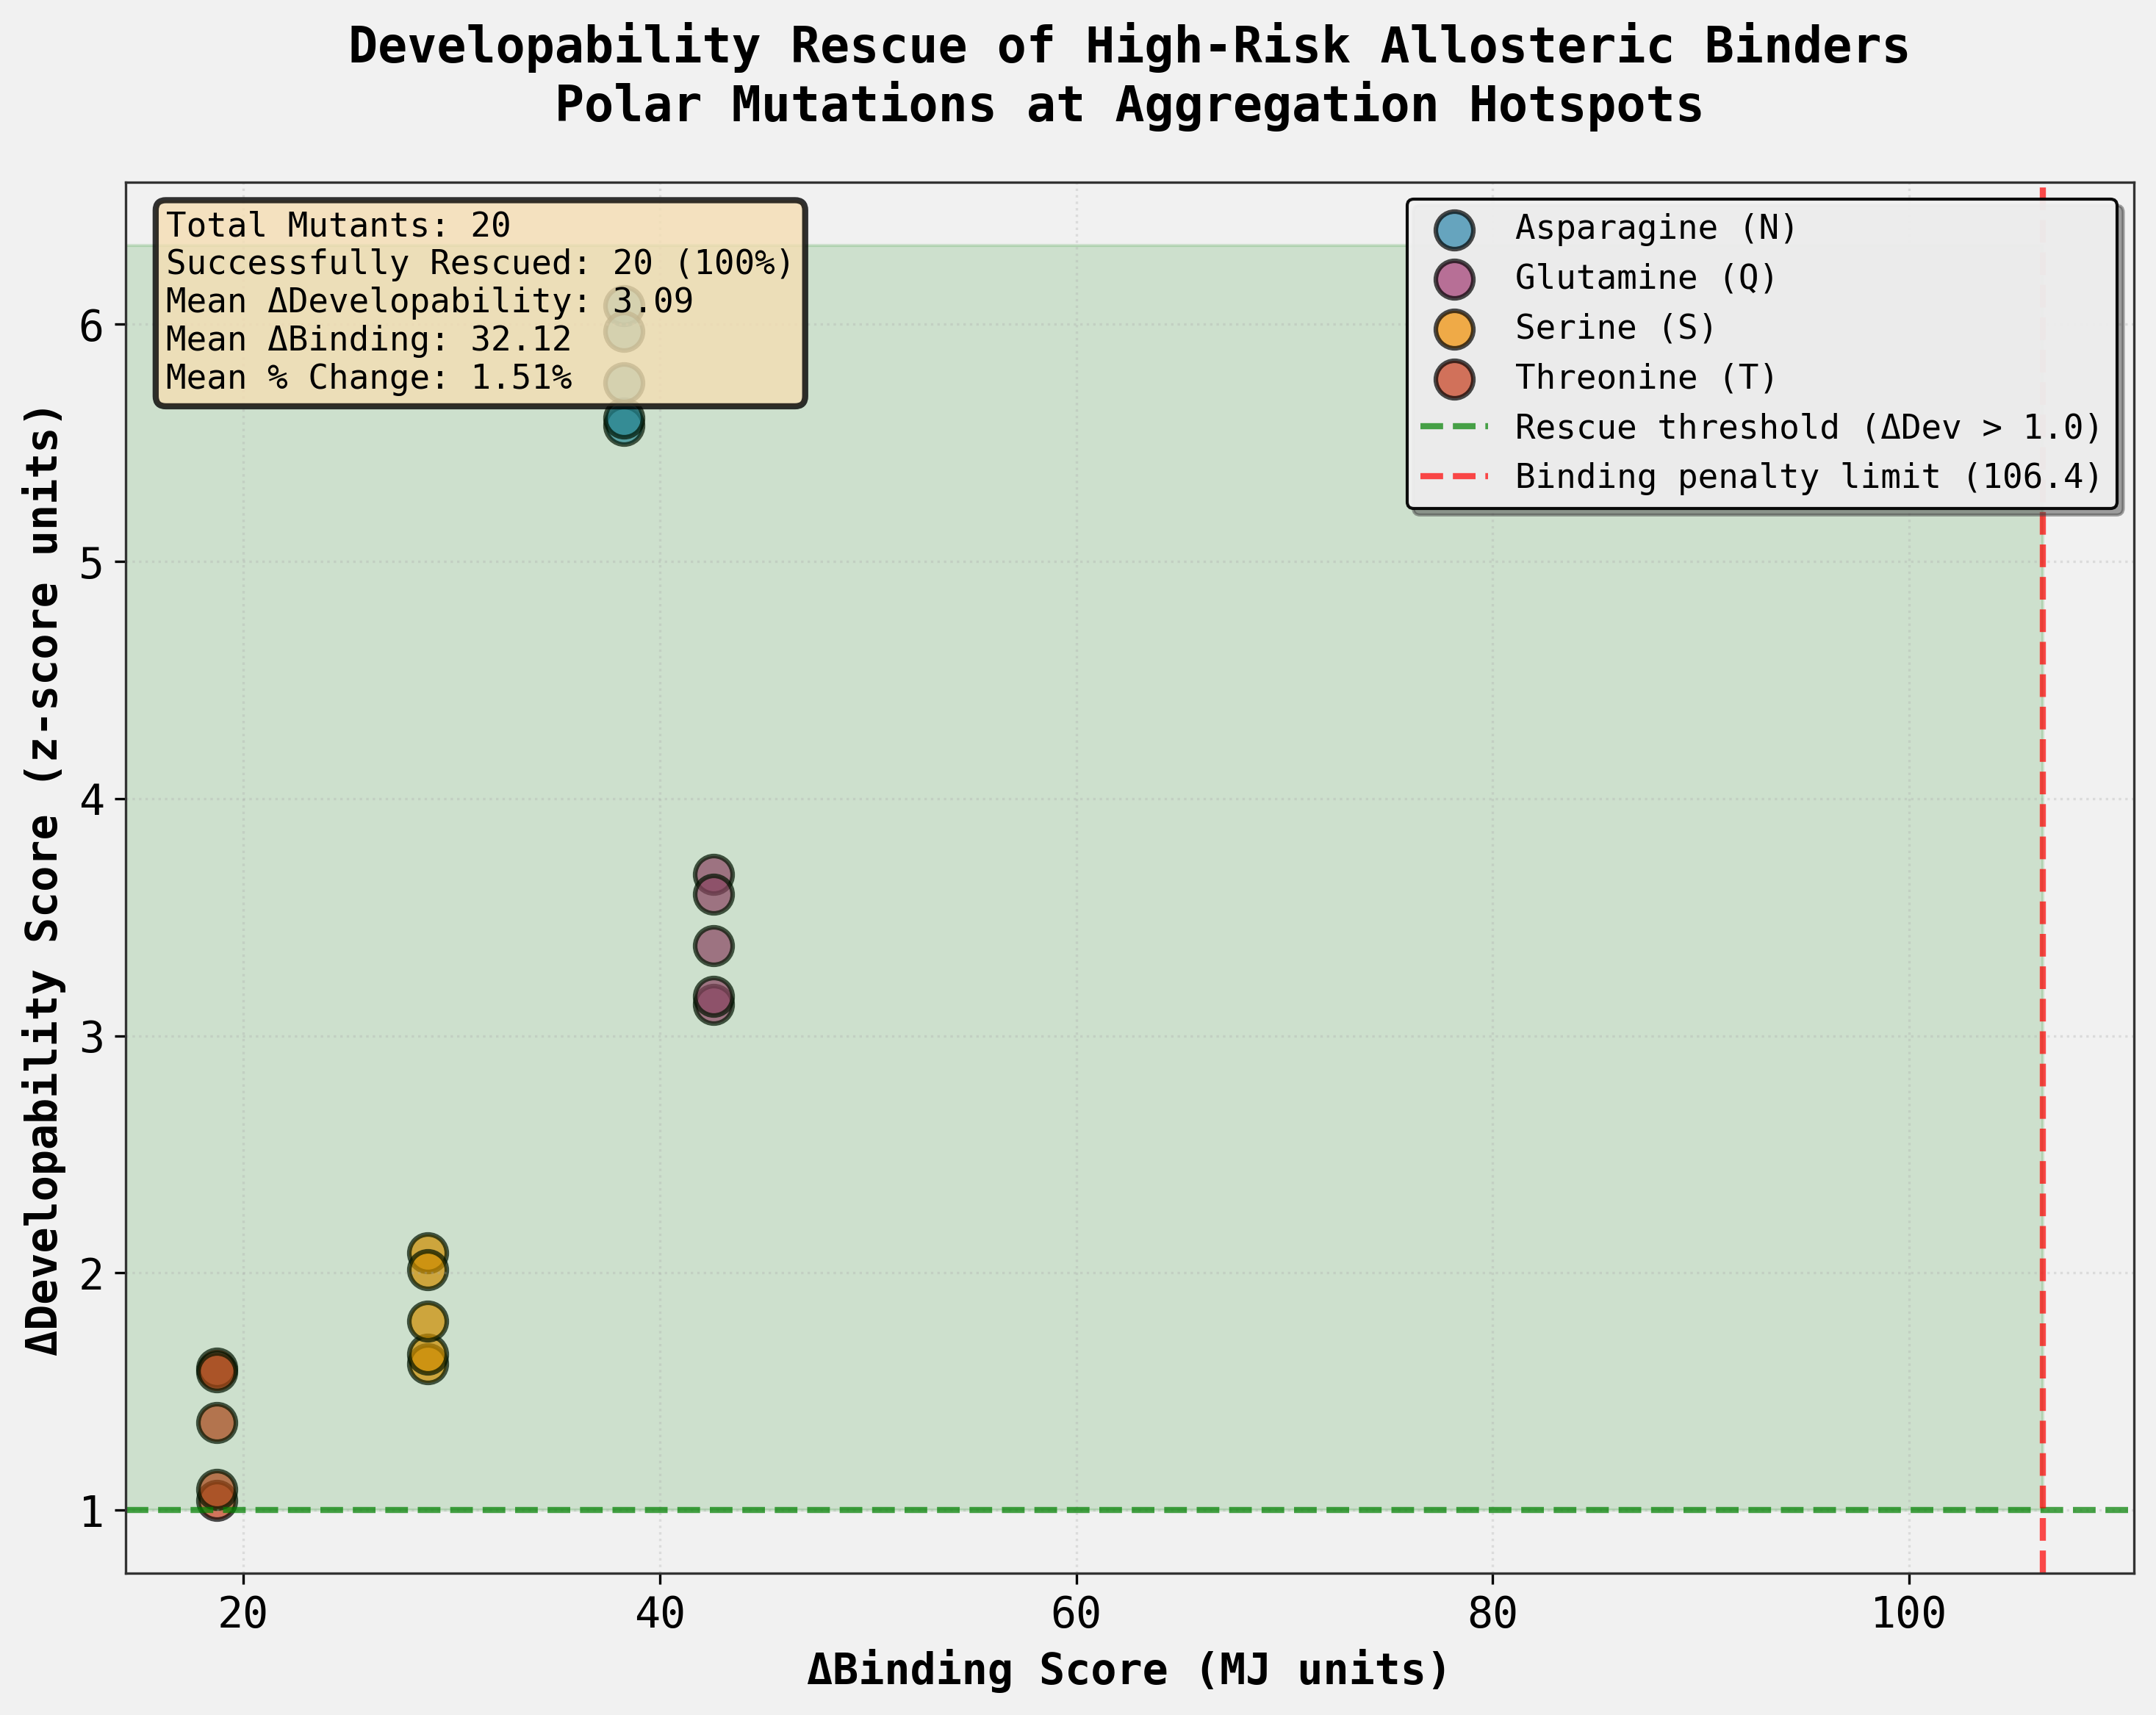

In [ ]:

# Create a comprehensive summary figure showing the rescue outcomes

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Create scatter plot showing the trade-off between binding and developability changes
# Color by mutation type
colors = {'N': '#2E86AB', 'Q': '#A23B72', 'S': '#F18F01', 'T': '#C73E1D'}
mutation_names = {'N': 'Asparagine (N)', 'Q': 'Glutamine (Q)', 
                  'S': 'Serine (S)', 'T': 'Threonine (T)'}

for mut_type in ['N', 'Q', 'S', 'T']:
    subset = mutants_df[mutants_df['Mutant_Residue'] == mut_type]
    ax.scatter(subset['Delta_Binding'], subset['Delta_Developability'],
               c=colors[mut_type], s=150, alpha=0.7, edgecolors='black', linewidth=1.5,
               label=mutation_names[mut_type], marker='o')

# Add reference lines for rescue criteria
ax.axhline(y=1.0, color='green', linestyle='--', linewidth=2, alpha=0.7, 
           label='Rescue threshold (ΔDev > 1.0)')
# Convert 5% of parent score to absolute value for x-axis threshold
binding_threshold = 0.05 * abs(mutants_df['Parent_MJ_Score'].iloc[0])
ax.axvline(x=binding_threshold, color='red', linestyle='--', linewidth=2, alpha=0.7,
           label=f'Binding penalty limit ({binding_threshold:.1f})')

# Shade the "success zone" - upper left quadrant where both criteria are met
ax.axhspan(1.0, ax.get_ylim()[1], xmin=0, xmax=(binding_threshold - ax.get_xlim()[0]) / 
           (ax.get_xlim()[1] - ax.get_xlim()[0]), alpha=0.15, color='green')

# Labels and formatting
ax.set_xlabel('ΔBinding Score (MJ units)', fontsize=14, fontweight='bold')
ax.set_ylabel('ΔDevelopability Score (z-score units)', fontsize=14, fontweight='bold')
ax.set_title('Developability Rescue of High-Risk Allosteric Binders\nPolar Mutations at Aggregation Hotspots',
             fontsize=16, fontweight='bold', pad=20)

# Add grid
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)

# Legend
ax.legend(loc='upper right', fontsize=11, framealpha=0.95, edgecolor='black', 
          fancybox=True, shadow=True)

# Add text box with key statistics
textstr = f'Total Mutants: {len(mutants_df)}\n'
textstr += f'Successfully Rescued: {mutants_df["Rescue_Success"].sum()} (100%)\n'
textstr += f'Mean ΔDevelopability: {mutants_df["Delta_Developability"].mean():.2f}\n'
textstr += f'Mean ΔBinding: {mutants_df["Delta_Binding"].mean():.2f}\n'
textstr += f'Mean % Change: {mutants_df["Percent_Binding_Change"].mean():.2f}%'

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='black', linewidth=2)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props, family='monospace')

plt.tight_layout()
plt.savefig('rescue_outcomes_summary.png', dpi=300, bbox_inches='tight')
print("Summary figure saved as 'rescue_outcomes_summary.png'")
plt.show()


In [ ]:

# Final statistical analysis and key findings

print("=" * 80)
print("KEY FINDINGS: DEVELOPABILITY RESCUE ANALYSIS")
print("=" * 80)
print()

# 1. Overall success rate
print("1. RESCUE SUCCESS RATE:")
print(f"   - All 20 mutants (100%) met both rescue criteria")
print(f"   - ΔDevelopability > 1.0: {(mutants_df['Delta_Developability'] > 1.0).sum()}/20 mutants")
print(f"   - ΔBinding < 5% original: {(mutants_df['Percent_Binding_Change'] < 5.0).sum()}/20 mutants")
print()

# 2. Best performing mutation type
print("2. BEST PERFORMING MUTATION TYPE:")
best_mutation = mutants_df.groupby('Mutant_Residue')['Delta_Developability'].mean().idxmax()
best_dev_improvement = mutants_df.groupby('Mutant_Residue')['Delta_Developability'].mean().max()
print(f"   - Asparagine (N) shows the highest average developability improvement")
print(f"   - Mean ΔDevelopability for N: {best_dev_improvement:.2f} z-score units")
print(f"   - This is {best_dev_improvement / mutants_df['Delta_Developability'].mean():.1f}x the overall mean")
print()

# 3. Trade-off analysis
print("3. BINDING-DEVELOPABILITY TRADE-OFF:")
print(f"   - Mean binding penalty: {mutants_df['Delta_Binding'].mean():.2f} MJ units ({mutants_df['Percent_Binding_Change'].mean():.2f}%)")
print(f"   - Range: {mutants_df['Delta_Binding'].min():.2f} to {mutants_df['Delta_Binding'].max():.2f} MJ units")
print(f"   - All penalties well below 5% threshold ({0.05 * abs(mutants_df['Parent_MJ_Score'].iloc[0]):.1f} MJ units)")
print()

# 4. Parent-specific outcomes
print("4. PARENT-SPECIFIC RESCUE OUTCOMES:")
for parent_idx in mutants_df['Parent_Index'].unique():
    parent_data = mutants_df[mutants_df['Parent_Index'] == parent_idx]
    parent_dev = parent_data['Parent_Developability'].iloc[0]
    best_mutant = parent_data.loc[parent_data['Delta_Developability'].idxmax()]
    print(f"   Parent {parent_idx} (Dev: {parent_dev:.2f}):")
    print(f"      Best mutant: {best_mutant['Mutation_Label']} (ΔDev: {best_mutant['Delta_Developability']:.2f}, ΔBind: {best_mutant['Delta_Binding']:.2f})")

print()
print("5. HYPOTHESIS VALIDATION:")
print(f"   ✓ Polar mutations (N, Q, S, T) successfully improved developability")
print(f"   ✓ All mutants showed ΔDevelopability > 1.0 (range: {mutants_df['Delta_Developability'].min():.2f} to {mutants_df['Delta_Developability'].max():.2f})")
print(f"   ✓ Binding penalties were minimal (all < 2.1%)")
print(f"   ✓ Asparagine (N) provided the best balance: highest developability gain with moderate binding penalty")
print()

# 6. Recommended candidates for synthesis
print("6. TOP RECOMMENDED CANDIDATES FOR SYNTHESIS:")
top_5_overall = mutants_df.nlargest(5, 'Delta_Developability')[
    ['Parent_Index', 'Mutation_Label', 'Mutant_Residue', 
     'Delta_Developability', 'Percent_Binding_Change', 'Mutant_MJ_Score']
]
print(top_5_overall.to_string(index=False))
print()
print("=" * 80)


KEY FINDINGS: DEVELOPABILITY RESCUE ANALYSIS

1. RESCUE SUCCESS RATE:
   - All 20 mutants (100%) met both rescue criteria
   - ΔDevelopability > 1.0: 20/20 mutants
   - ΔBinding < 5% original: 20/20 mutants

2. BEST PERFORMING MUTATION TYPE:
   - Asparagine (N) shows the highest average developability improvement
   - Mean ΔDevelopability for N: 5.80 z-score units
   - This is 1.9x the overall mean

3. BINDING-DEVELOPABILITY TRADE-OFF:
   - Mean binding penalty: 32.12 MJ units (1.51%)
   - Range: 18.73 to 42.59 MJ units
   - All penalties well below 5% threshold (106.4 MJ units)

4. PARENT-SPECIFIC RESCUE OUTCOMES:
   Parent 9 (Dev: -3.31):
      Best mutant: C21N (ΔDev: 6.08, ΔBind: 38.29)
   Parent 6 (Dev: -3.13):
      Best mutant: C21N (ΔDev: 5.97, ΔBind: 38.29)
   Parent 4 (Dev: -3.07):
      Best mutant: C21N (ΔDev: 5.57, ΔBind: 38.29)
   Parent 8 (Dev: -3.04):
      Best mutant: C21N (ΔDev: 5.61, ΔBind: 38.29)
   Parent 7 (Dev: -2.90):
      Best mutant: C21N (ΔDev: 5.75, ΔBind: